## US Retail Sales - Time Series Analysis

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
sales_df = pd.read_csv('us_retail_sales.csv')
sales_df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


**Cleaning Up the Data**

In order to use the data for timeseries analysis, we will have to reformat it. I will first melt the data so that there is one row for each date, then convert the values to datetime.

In [3]:
sales_dff = sales_df.melt(id_vars='YEAR', 
                           value_vars=['JAN', 'FEB', 'MAR', 'APR',
                                       'MAY', 'JUN', 'JUL', 'AUG',
                                       'SEP', 'OCT', 'NOV', 'DEC'])

sales_dff['month'] = sales_dff['YEAR'].astype(str) + '-' + sales_dff['variable']
sales_dff.drop(['YEAR', 'variable'], axis=1, inplace=True)

sales_dff['month'] = pd.to_datetime(sales_dff['month'], format='%Y-%b')

sales_dff.sort_values(by='month', inplace=True)
sales_dff = sales_dff.set_index('month')

sales_dff = sales_dff.rename(columns={'value': 'sales'})

sales_dff.head()

,sales
month,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


**1. Plot the Data**

The first plot we will look at is what the typical yearly trend looks like. This will give us an understanding of which months typically see high sales and which months typically see lower sales.

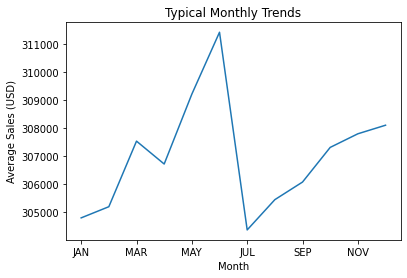

In [4]:
sales_dfv = sales_df.set_index('YEAR')
sales_dfv.mean().plot()

plt.xlabel('Month')
plt.ylabel('Average Sales (USD)')

plt.title('Typical Monthly Trends')

plt.show()

We can see, looking at the plot, that sales typically are higher in the late spring as well as Christmas time. They are typically the lowest in July and January. 

The next plot we will look at will show us the yearly sales for each year represented in the dataset.

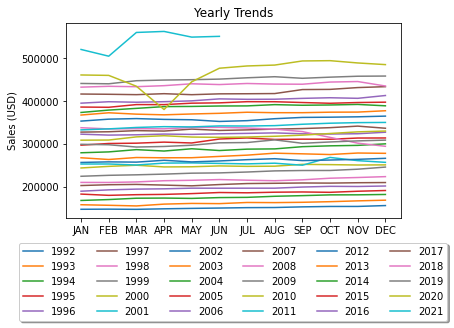

In [5]:
fig = plt.figure()
ax = plt.subplot(111)

for index, row in sales_dfv.iterrows():
    plt.plot(row, label=index)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=6)

plt.ylabel('Sales (USD)')

plt.title('Yearly Trends')

plt.show()

Looking at this plot, we can see the sale trends for each year from 1992 to 2021. This graph demonstrates that the monthly fluctuations are actually less volatile than the yearly changes in sales. Typically, it looks like each year has a noticeably higher trend line than the previous year. This indicates to us that sales are going up year after year. There are of course a few noticeable exceptions to this. The 2020 line has a very dramatic dip around March-April which visually indicates the effects of the Covid-19 crisis.

The final plot we will look at is the trendline showing how sales have fluctuated over time from 1992 to 2021.

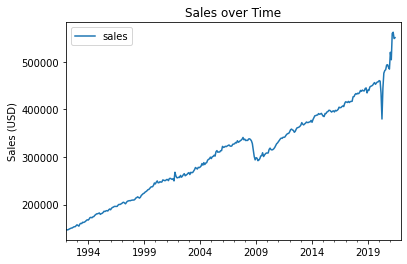

In [6]:
sales_dff.plot()

plt.ylabel('Sales (USD)')
plt.xlabel('')

plt.title('Sales over Time')

plt.show()

This plot shows us that there is a general upwards trend over time, though we can see clear dips in 2009 and 2020 indicating periods of recession.

**2. Split into Train/Test Set**

In [7]:
sales_dff = sales_dff[:-6]

train = sales_dff[:-12]
test = sales_dff[-12:]

**3. Build a Predictive Model**

In [8]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

In [12]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  342
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3442.629
Date:                Thu, 04 May 2023   AIC                           6897.257
Time:                        16:18:22   BIC                           6920.249
Sample:                    01-01-1992   HQIC                          6906.417
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0087      0.009     -0.952      0.341      -0.027       0.009
ar.L2         -0.1073      0.015     -7.206      0.000      -0.136      -0.078
ar.L3         -0.0159      0.046     -0.343      0.7

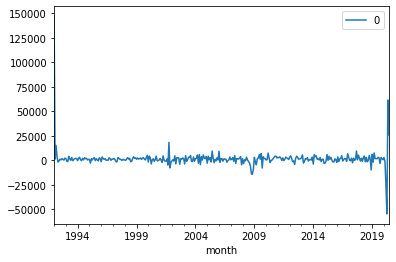

In [13]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

Our residual plot shows a couple timeframes where the errors are not well-represented by the model. Most notably, at the end of the test timeframe, there is quite a bit of unexplained error circa the late-2019 to early-2020 period. This will likely make it difficult to predict the future as the most recent and relevant periods are highly fluctuating and influenced by outside factors (as opposed to the typical yearly trends).

In [14]:
print(residuals.describe())

                   0
count     342.000000
mean     1501.514903
std      9761.782556
min    -54706.736260
25%      -412.478813
50%      1228.902363
75%      2560.567074
max    146925.000000


**4. Predict Sales for Last Year of Data**

**ARIMA Model**

In [15]:
sales_dff['forecast_a'] = model_fit.predict(start=342, end=354, dynamic=True)
test['pred'] = sales_dff['forecast_a'][-12:]

<AxesSubplot:xlabel='month'>

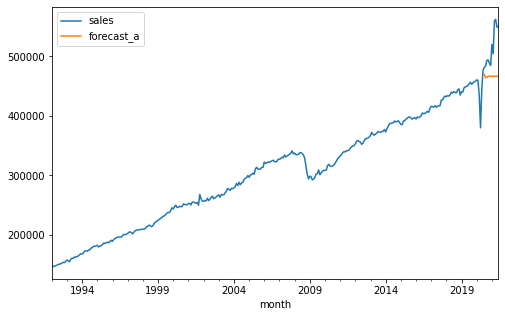

In [16]:
sales_dff[['sales', 'forecast_a']].plot(figsize=(8, 5))

The orange line in the plot above demonstrates the model's predicted values for the test timeframe. The blue line shows the actual recorded sales. The model predicts very little change in sales during the test time period.

**5. Report the RMSE**

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [18]:
rmse = sqrt(mean_squared_error(test['sales'], test['pred']))
rmse

57005.76983475838

The ARIMA model has a very high RMSE, and if we look at the graphical output we can see that the predictions are essentially a straight line. There are no increases or fluctuations predicted by the model. This model is not a good predictor of future sales.

**SARIMA Model**

Since the ARIMA model was unsuccessful, we will now try creating a SARIMA model to see if we can improve upon it. The SARIMA model takes into account overall trends, but notably also includes an additional factor: seasonality.

In [19]:
import statsmodels.api as sm

In [20]:
model2=sm.tsa.statespace.SARIMAX(train,order=(2,1,2),seasonal_order=(2,1,2,12))
result2=model2.fit()

In [21]:
sales_dff['forecast_s']=result2.predict(start=342, end=354, dynamic=True)
test['pred2'] = sales_dff['forecast_s'][-12:]

<AxesSubplot:xlabel='month'>

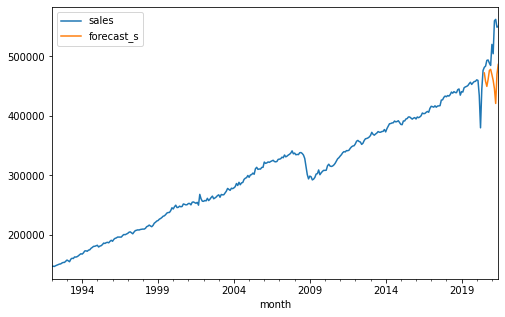

In [22]:
sales_dff[['sales', 'forecast_s']].plot(figsize=(8, 5))

In [23]:
rmse = sqrt(mean_squared_error(test['sales'], test['pred2']))
rmse

65785.24969260208

This initial SARIMA model actually has a higher RMSE than our ARIMA model. This model assumes that p=2, q=1, d=2 and m=12. This model seems to rely to heavily on the prior year, assuming a big dip to occur in the spring in 2021 just as it did in 2020. This assumption has undue influence on our model. We will take a look and see if we can tune the hyperparameters to make it more effective.

**Tuning Hyperparameters**

After trying a few models, I discovered the most optimal hyperparameters for this SARIMA model are p=2, q=2, d=2 and m=3. The m=3 indicates to us that the sales trends tend to fall in a quarterly pattern, meaning each "season" in the data covers 3 periods, or 3 months, resulting in there being 4 distinct quarters in the calendar year. This is a bit counterintuitive since the data is recorded monthly, I would have expected the optimal value to be 12. However, the m=3 model performs significantly better than the m=12 (and for that matter, the m=6) model.

In [27]:
model3=sm.tsa.statespace.SARIMAX(train,order=(2,2,2),seasonal_order=(2,2,2,3))
result3=model3.fit()

In [28]:
sales_dff['forecast_s2']=result3.predict(start=342, end=354, dynamic=True)
test['pred3'] = sales_dff['forecast_s2'][-12:]

<AxesSubplot:xlabel='month'>

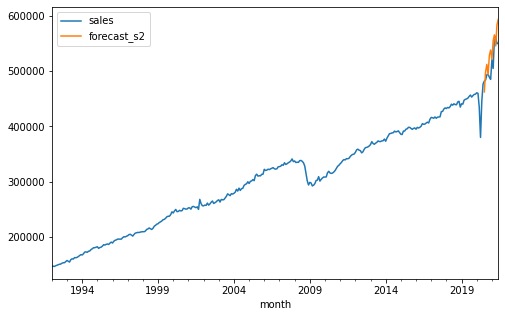

In [29]:
sales_dff[['sales', 'forecast_s2']].plot(figsize=(8, 5))

In [30]:
rmse = sqrt(mean_squared_error(test['sales'], test['pred3']))
rmse

30430.632274900305

This model significantly decreases our RMSE. By tuning the hyperparameters to fine tune the lag and seasonality variables, we were able to create a model that is able to more accurately predict the sales trends in our test data. This model thankfully does not over-emphasize the Spring 2020 dip and instead displays a consistently increasing orange trendline on our graph. This indicates that sales are overall increasing, but there are smaller quarterly fluctuations at play.